In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
from IPython.display import Audio

# Nachtrag zum Übungsblatt: STFT | Heisenberg

In [2]:
sr = 8000
window_size = 266 # trying out different window-sizes
nyquist = sr / 2

f_res = sr / window_size

print('Freq-resolution:\t:', f_res)

np.arange(0, nyquist, f_res) # this would be the frequencies for each bin with the given window size

Freq-resolution:	: 30.075187969924812


array([   0.        ,   30.07518797,   60.15037594,   90.22556391,
        120.30075188,  150.37593985,  180.45112782,  210.52631579,
        240.60150376,  270.67669173,  300.7518797 ,  330.82706767,
        360.90225564,  390.97744361,  421.05263158,  451.12781955,
        481.20300752,  511.27819549,  541.35338346,  571.42857143,
        601.5037594 ,  631.57894737,  661.65413534,  691.72932331,
        721.80451128,  751.87969925,  781.95488722,  812.03007519,
        842.10526316,  872.18045113,  902.2556391 ,  932.33082707,
        962.40601504,  992.48120301, 1022.55639098, 1052.63157895,
       1082.70676692, 1112.78195489, 1142.85714286, 1172.93233083,
       1203.0075188 , 1233.08270677, 1263.15789474, 1293.23308271,
       1323.30827068, 1353.38345865, 1383.45864662, 1413.53383459,
       1443.60902256, 1473.68421053, 1503.7593985 , 1533.83458647,
       1563.90977444, 1593.98496241, 1624.06015038, 1654.13533835,
       1684.21052632, 1714.28571429, 1744.36090226, 1774.43609

# Logarithmus-Frequenz-Skaliertes Spektrogramm

(Log-Freq-Spec)

In [3]:
!curl https://cdn.freesound.org/previews/94/94812_29541-lq.mp3 -o piano_scale.mp3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 78792  100 78792    0     0  74192      0  0:00:01  0:00:01 --:--:-- 74192


In [4]:
x, sr = lr.load('piano_scale.mp3', sr=None) # sr=None for file-based sr

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [5]:
display(Audio(x, rate=sr))

In [6]:
window_size = 4096

stft = lr.stft(x, n_fft=window_size)

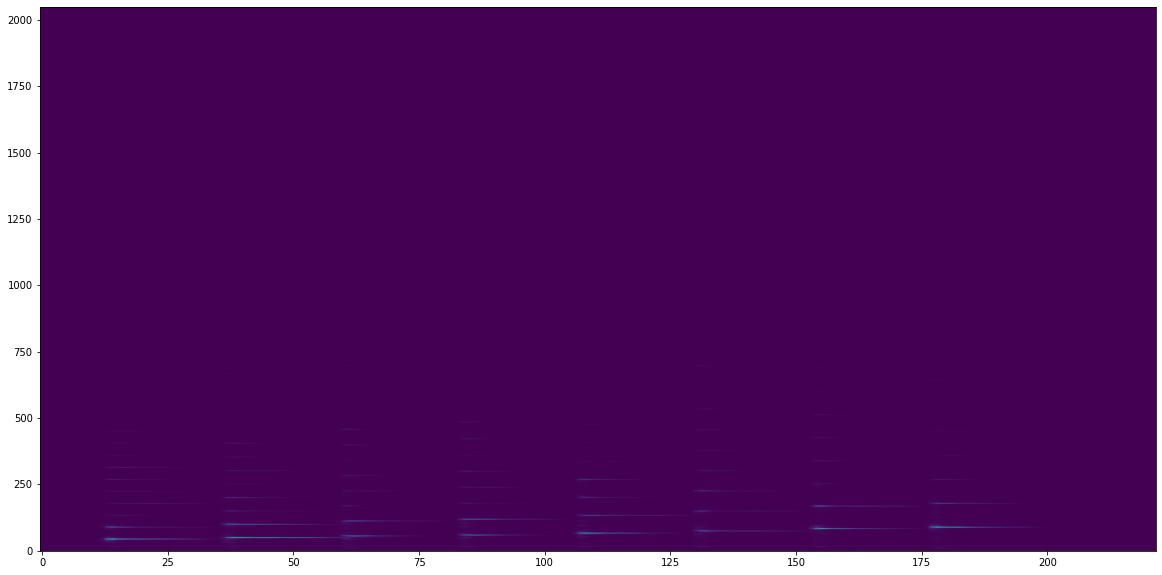

In [7]:
plt.figure(figsize=(20, 10))
plt.imshow(np.abs(stft), aspect='auto', origin='lower')
plt.show()

## Side-Note: Log-Gamma-Compression

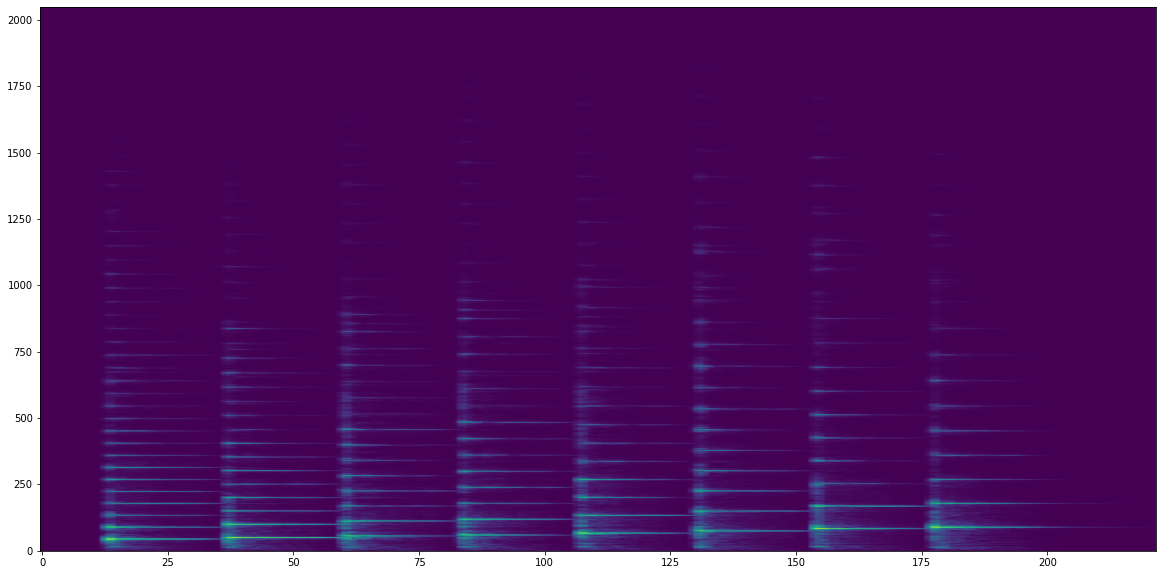

In [8]:
gamma = 1
stft_g = np.log10(1 + np.abs(stft) * gamma)

plt.figure(figsize=(20, 10))
plt.imshow(np.abs(stft_g), aspect='auto', origin='lower')
plt.show()

## Fahrplan

- Welche bins entsprechen einem gegebenen Pitch `p`?
    - (p +- 0.5) range
    - midi_to_frequency
    - f_coef in stft
- sum bins per pitch

In [9]:
def midi_to_frequency(p):
    return 440 * 2 ** ((p - 69) / 12)

print(midi_to_frequency(69))
print(midi_to_frequency(68))
print(midi_to_frequency(69 - 12))
print(midi_to_frequency(69 - 12 - 1))
print(midi_to_frequency(60))

440.0
415.3046975799451
220.0
207.65234878997256
261.6255653005986


In [10]:
def f_coef(k, sr, window_size):
    return sr * k / window_size

print(f_coef(k=1, sr=sr, window_size=window_size))

5.859375


In [12]:
def freqs_in_dft(p, window_size, sr):

    f_coefs = f_coef(k=np.arange(0, window_size), sr=sr, window_size=window_size)

    freqs = np.array([])

    for f in f_coefs:
        if (f > midi_to_frequency(p - 0.5) and (f < midi_to_frequency(p + 0.5))):
            freqs = np.append(freqs, f)
    
    return freqs
          
print(freqs_in_dft(69, window_size, sr))
print(freqs_in_dft(68, window_size, sr))
print(freqs_in_dft(69 - 12, window_size, sr))
print(freqs_in_dft(69 - 12 * 2, window_size, sr))

[427.734375 433.59375  439.453125 445.3125   451.171875]
[404.296875 410.15625  416.015625 421.875   ]
[216.796875 222.65625 ]
[111.328125]


In [14]:
def ks_in_dft(p, window_size, sr):

    f_coefs = f_coef(k=np.arange(0, window_size // 2), sr=sr, window_size=window_size)

    ks = np.array([], dtype=int)

    for k, f in enumerate(f_coefs):
        if (f > midi_to_frequency(p - 0.5) and (f < midi_to_frequency(p + 0.5))):
            ks = np.append(ks, k)
    
    return ks
          
print(ks_in_dft(69, window_size, sr))
print(ks_in_dft(68, window_size, sr))
print(ks_in_dft(69 - 12, window_size, sr))
print(ks_in_dft(69 - 12 * 2, window_size, sr))

[73 74 75 76 77]
[69 70 71 72]
[37 38]
[19]


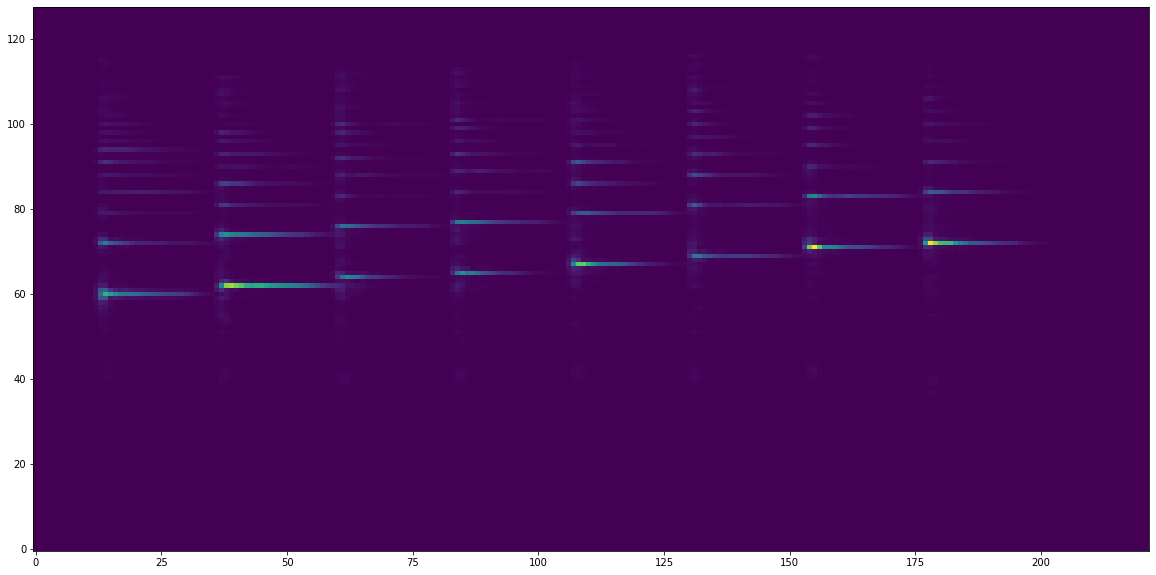

In [15]:
def logfreq_from_stft(stft, sr, window_size):

    logfreq = np.zeros((128, stft.shape[1]))

    for p in range(128):
    
        ks = ks_in_dft(p, window_size, sr)
    
        for k in ks:
            logfreq[p] = logfreq[p] + stft[k]
    
    return logfreq

logfreq = logfreq_from_stft(np.abs(stft), sr, window_size)

plt.figure(figsize=(20, 10))
plt.imshow(logfreq, aspect='auto', origin='lower')
plt.show()